In [1]:
MODEL_CLASS = "COMET"
DATA_NAME = "movielens"
MODEL_NAME = f"{MODEL_CLASS}_{DATA_NAME}"

In [2]:
LEARNING_TYPE = "pointwise"
DATA_LOADING_TYPE = "general"
TRN_NEG_PER_POS = 4
TRN_BATCH_SIZE = 256

In [3]:
WORK_DIR_PATH = "../.."

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# WORK_DIR_PATH = "/content/drive/MyDrive/RS-COMET/"

# Constants

In [ ]:
# split
TST_NEG_PER_POS = 99
LOO_NEG_PER_POS = TST_NEG_PER_POS
TST_BATCH_SIZE = TRN_BATCH_SIZE
LOO_BATCH_SIZE = 1000
N_PHASES = 10 if DATA_LOADING_TYPE=="phase" else None
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
NEG_PER_POS = [TRN_NEG_PER_POS, TRN_NEG_PER_POS, TST_NEG_PER_POS, LOO_NEG_PER_POS]
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, TST_BATCH_SIZE, LOO_BATCH_SIZE]
MAX_HIST = 50
SHUFFLE = False if DATA_LOADING_TYPE=="curriculum" else True

In [6]:
# Model
import itertools

N_FACTORS = 32
DROPOUT = 0.2
CHANNELS = 8
KERNEL_WIDTH = [1, N_FACTORS//4, N_FACTORS//2, N_FACTORS]
STRIDE = 1

unit_max = CHANNELS * sum([(N_FACTORS - window) // STRIDE + 1 for window in KERNEL_WIDTH])
condition = lambda unit: unit <= unit_max
interable = (N_FACTORS * (2**N) for N in itertools.count(start=0, step=2))
hidden_rev = list(itertools.takewhile(condition, interable))
hidden_rev.append(unit_max)
HIDDEN = hidden_rev[::-1]

In [7]:
# how to learn
LEARNING_RATE = 1e-4 if TRN_BATCH_SIZE==256 else 1e-3
LAMBDA_ = 1e-3

In [8]:
# how to monitor
METRIC_FN = "ndcg"
PATIENCE = 5
MIN_DELTA = 1e-3

In [9]:
# how to loop
N_EPOCHS = 1000
WARM_UP = 10
INTERVAL = 1

# Config

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\PAPER REVIEW\RECSYS\08_RS-COMET


In [12]:
import pandas as pd
import torch
from COMET import comet
import UTILS
from LOOP.loop import TrainingLoop
from LOOP.monitor.monitor import EarlyStoppingMonitor
from LOOP.predictor.predictor import PerformancePredictor
from LOOP.evaluator.evaluator import PerformanceEvaluator

In [13]:
if LEARNING_TYPE=="pairwise":
    from DATA_SPLITTER.pairwise import trn_val_tst
    from LOOP.trainer.pairwise import PairwiseTrainer as Trainer
    from LOOP.loss_fn.bpr import bpr_func as task_fn

elif LEARNING_TYPE=="pointwise":
    from DATA_SPLITTER.pointwise import trn_val_tst
    from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
    from LOOP.loss_fn.bce import bce_func as task_fn

else:
    ValueError()

In [14]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [15]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [16]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [17]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [18]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [19]:
# data Description
UTILS.data_handler.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
max interaction of item: 329
top 10.0 % interaction of user: 400.3
top 10.0 % interaction of item: 27.0
mean interaction of user: 165
mean interaction of item: 10


In [20]:
kwargs = dict(
    origin=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    loading_type=DATA_LOADING_TYPE,
)

dataloader = trn_val_tst.DataSplitter(**kwargs)

In [ ]:
kwargs = dict(
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS,
    batch_size=BATCH_SIZE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, (user_hist, item_hist) = dataloader.get(**kwargs)

In [22]:
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [23]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
    hidden=HIDDEN,
    dropout=DROPOUT,
    channels=CHANNELS,
    kernel_width=KERNEL_WIDTH,
    stride=STRIDE,
    user_hist=user_hist,
    item_hist=item_hist,
)

model = comet.model.Module(**kwargs)

In [24]:
kwargs = dict(
    model=model,
    task_fn=task_fn,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [25]:
kwargs = dict(
    model=model,
    metric_fn=METRIC_FN,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [26]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

loop = TrainingLoop(**kwargs)

# Train

In [27]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    warm_up=WARM_UP,
    interval=INTERVAL,
)

history = loop.fit(**kwargs)

LEAVE ONE OUT
	BEST SCORE: 0.5003
	BEST EPOCH: 18
COMPUTING COST FOR LEARNING
	(s/epoch): 0.7892
	(epoch/s): 1.2671
	(s/batch): 0.0210
	(batch/s): 47.6539


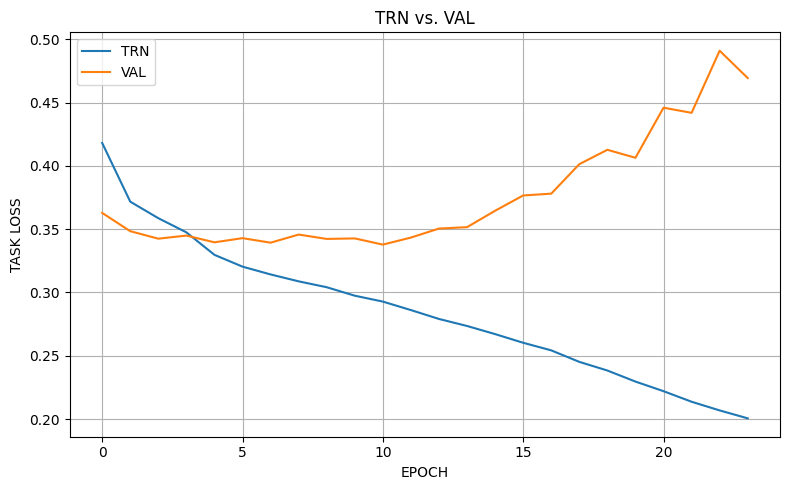

In [28]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [29]:
predictor = PerformancePredictor(model)

In [30]:
result = predictor.predict(tst_loader)

COMPUTING COST FOR INFERENCE
	(s/epoch): 27.4653
	(epoch/s): 0.0364
	(s/batch): 0.0070
	(batch/s): 142.5799


In [31]:
evaluator = PerformanceEvaluator(result)

In [32]:
eval = evaluator.evaluate()
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.731148,0.271803,0.212460,0.145126,0.329676
1,10,0.870492,0.218689,0.329199,0.180700,0.349451
2,15,0.927869,0.186557,0.399923,0.197352,0.366149
3,20,0.952459,0.169016,0.457461,0.208621,0.383210
4,25,0.967213,0.152197,0.498573,0.215701,0.394214
5,50,0.993443,0.109148,0.630583,0.234251,0.435257
6,100,0.998361,0.072787,0.739530,0.245966,0.472431


# Save

In [33]:
PATH = f'./_checkpoints/{LEARNING_TYPE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)